In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datareader.cleaner.lemas as cl
import simnet.similarity
import simnet.variety
from diffusion.simple_diff import get_diffusion_diff
from model_selection.stepwise import BackwardStepwise

from tqdm import tqdm

In [5]:
## Get the attribute data for agencies
INDEX_COL = "ORI9"
df, cat_cols, con_cols = cl.lemas_df_cols("Imputed_Lemas.csv")
df = df[~(df['ORI9']==' ')]

all_nodes = df[INDEX_COL]

## Define the similarity metric
cosine_sim_8 = simnet.similarity.CosineSimilarity(0.8)

## Get the entropy-filtered columns
cat_col_variety_full = {col: v
                   for col in cat_cols if (v:=simnet.variety.get_discrete_variety_score(df[col]))}
variety_p75 = np.percentile(list(cat_col_variety_full.values()), 50)
cat_col_variety_75 = [col for col, v in cat_col_variety_full.items() if v > variety_p75]
cols_to_include = cat_col_variety_75 + ["log_pop", "log_budget"]


In [6]:
df.set_index("ORI9")

,Unnamed: 0,LEAR_ID,AGENCYNAME,CITY,ZIPCODE,STATE,COUNTY,FIPS,POPSERVED,POPGROUP,...,ISSU_ADDR_SCH,ISSU_ADDR_SWAT,ISSU_ADDR_TERROR,ISSU_ADDR_VIC,FINALWGT,NEW_TOT_HIRES,NEW_TOT_SEP,FINALWGT_NTH_NTS,log_pop,log_budget
ORI9,,,,,,,,,,,,,,,,,,,,,
CA0570100,0,635592,DAVIS POLICE DEPARTMENT,DAVIS,95618,CA,YOLO,6113,68111,5,...,3,2,3,2,7.185185,5.703704,3.629630,7.533981,0.660713,0.783248
NJ0091200,1,645110,WEST NEW YORK POLICE,WEST NEW YORK,7093,NJ,HUDSON,34017,53343,5,...,3,2,2,3,1.131206,31.629433,26.578014,1.183673,0.546056,0.674355
WV0310400,2,631270,WESTOVER POLICE DEPARTMENT,WESTOVER,26501,WV,MONONGALIA,54061,4243,8,...,5,5,5,5,7.304746,1.027363,0.634328,7.607534,-0.641567,-0.694089
WI0570200,3,631316,BARABOO POLICE DEPARTMENT,BARABOO,53913,WI,SAUK,55111,12173,7,...,1,2,3,3,6.913793,3.047414,2.344828,7.225225,-0.147114,-0.001664
WI0137400,4,631684,OREGON POLICE DEPARTMENT,OREGON,53575,WI,DANE,55025,3334,8,...,2,5,5,3,6.978166,1.711790,1.235808,7.347126,-0.754676,-0.207605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NV0020100,2779,645361,LAS VEGAS METRO POLICE DEPARTMENT,LAS VEGAS,89106,NV,CLARK,32003,1592178,1,...,4,1,1,2,1.131206,354.000000,216.000000,1.183673,2.139320,2.334349
CA0190000,2780,635749,LOS ANGELES COUNTY SHERIFF'S DEPARTMENT,MONTEREY PARK,91754,CA,LOS ANGELES,6037,10137915,1,...,2,1,1,2,1.321033,460.000000,1694.000000,1.415020,3.007789,3.131008
ILCPD0000,2781,638583,CHICAGO POLICE DEPARTMENT,CHICAGO,60653,IL,COOK,17031,2704958,1,...,2,1,1,2,1.131206,595.000000,506.000000,1.183673,2.387959,2.763773


In [7]:
## Get the State dynamic
nibrs_df = pd.read_parquet("DATA/map_plot.pq")

## Filter those that are within the attribute data
dynamic = nibrs_df[nibrs_df["ORI"].isin(all_nodes)].assign(y = nibrs_df["NUMBER OF MONTHS REPORTED"]>0) \
    .pivot_table(index="ORI", columns="year", values="y", aggfunc='first').fillna(False)
dynamic

year,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ORI,,,,,,,,,,,,,,,,,,,,,
AK0010100,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AK0010300,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AK0011600,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
AK0015600,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
AL0010000,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY0150100,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
WY0190000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
WY0210000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True


In [8]:
common_agencies = sorted(set(dynamic.index) & set(df["ORI9"]))
df= df.set_index("ORI9").loc[common_agencies]

In [9]:
list(df.index) == list(dynamic.index)

True

In [10]:
cols_to_include.index('AGENCYTYPE')

123

## Test code change section

In [7]:
removal_dict:dict[str, int] = {}
logging:list[dict[str, int]] = []
cols_to_include_for_removal = cols_to_include.copy()
while (n:=len(cols_to_include_for_removal) )>=10:
    diff_dict = dict()
    for cat_col_i, col_name in enumerate(cols_to_include_for_removal):

        col_to_try = cols_to_include_for_removal[:cat_col_i] + cols_to_include_for_removal[cat_col_i+1:]
        sn = simnet.similarity.SimilarityNetwork(
            df,
            cosine_sim_8,
            col_to_try
        )
        W = sn.fit_transform().toarray()


        # ## Any way to improve performance?
        # G = sn.network.subgraph(dynamic.index)

        # W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
        diff = get_diffusion_diff(
            np.matrix(W),
            dynamic.to_numpy(dtype=int),
            0.5
        )

        diff_dict[col_name] = diff

    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    worst_col =  list(rank_by_se.keys())[0] ## Remove this columns yields the best performance improve
    logging.append(rank_by_se)
    removal_dict[worst_col] = rank_by_se[worst_col]
    print(n, worst_col, rank_by_se[worst_col], sep='\t')
    cols_to_include_for_removal.remove(worst_col)

131
131	AGENCYTYPE	3051
130
130	EQ_AUTH_EXP	3035
129
129	ISSU_ADDR_REPOFF	3002
128
128	POL_MAXHRS	3000
127
127	TECH_IFC_DRVREC	2948
126
126	TECH_WEB_REPORT	2966
125
125	log_pop	2944
124
124	EQ_BCK_CASH	2931
123
123	ISSU_ADDR_VIC	2929
122
122	PERS_CULTURE	2938
121
121	CP_SURV_CRPROB	2923
120
120	ISSU_ADDR_HUMTRF	2933
119
119	ISSU_ADDR_MISCHD	2895
118
118	TECH_IFC_ADDHIS	2853
117
117	TECH_FILE_COMPL	2852
116
116	EQ_VEH_ARMOR	2869
115
115	POL_INV_ICD	2864
114
114	CP_SURV_PERFORM	2834
113
113	TECH_FILE_PRTORD	2852
112
112	TECH_WEB_STAT	2806
111
111	TECH_WEB_COMPL	2810
110
110	POL_VEHPURS	2796
109
109	CP_SURV_RESOURCE	2790
108
108	CP_CPACAD	2802
107
107	EQ_DOC_NECK	2786
106
106	TECH_SM_TWITTER	2777
105
105	EQ_AUTH_CHEM	2784
104
104	TECH_TYP_LPR	2805
103
103	POL_TERROR	2811
102
102	ISSU_ADDR_CRMANL	2814
101
101	TECH_WEB_STOP	2788
100
100	TECH_FILE_INFORM	2815
99
99	CP_SURV_POLICY	2810
98
98	EQ_VEH_MTRCYCL	2811
97
97	TECH_IFC_PRTORD	2801
96
96	ISSU_ADDR_SWAT	2804
95
95	ISSU_ADDR_GUNS	2781
94


In [32]:
# import pickle

# with open("back_7.pkl", 'wb') as f:
#     pickle.dump(logging_7, f)

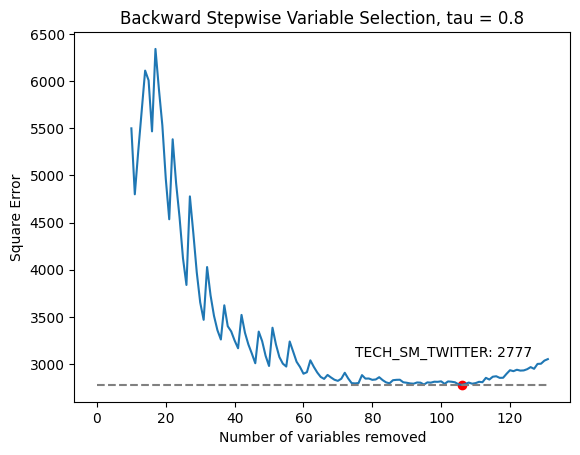

In [27]:
from matplotlib import pyplot as plt


plt.plot([131-n for n in range(len(removal_dict))], removal_dict.values())
min_value_col, min_value = sorted(removal_dict.items(), key=lambda item: item[1])[0]
plt.hlines(y = min_value, xmin=0, xmax=131, linestyles='--', colors='grey')
plt.annotate(f"{min_value_col}: {min_value}", (75, min_value+300))
plt.scatter(x = 106, y = min_value, c='r')
plt.xlabel("Number of variables removed")
plt.ylabel("Square Error")
plt.title("Backward Stepwise Variable Selection, tau = 0.8");

In [28]:

cosine_sim_7 = simnet.similarity.CosineSimilarity(0.7)

removal_dict_7:dict[str, int] = {}
logging_7:list[dict[str, int]] = []
cols_to_include_for_removal = cols_to_include.copy()

while (n:=len(cols_to_include_for_removal) )>=10:
    diff_dict = dict()
    for cat_col_i, col_name in enumerate(cols_to_include_for_removal):

        col_to_try = cols_to_include_for_removal[:cat_col_i] + cols_to_include_for_removal[cat_col_i+1:]
        sn = simnet.similarity.SimilarityNetwork(
            df,
            cosine_sim_7,
            col_to_try
        )
        W = sn.fit_transform().toarray()
        # G = sn.network.subgraph(dynamic.index)

        # W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
        diff = get_diffusion_diff(
            np.matrix(W),
            dynamic.to_numpy(dtype=int),
            0.5
        )

        diff_dict[col_name] = diff

    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    worst_col =  list(rank_by_se.keys())[0] ## Remove this columns yields the best performance improve
    logging_7.append(rank_by_se)
    removal_dict_7[worst_col] = rank_by_se[worst_col]
    print(n, worst_col, rank_by_se[worst_col], sep='\t')
    cols_to_include_for_removal.remove(worst_col)

131	EQ_REV_ON_PRIM	5316
130	TECH_FILE_PRTORD	5234
129	TECH_IFC_GISMAP	4996
128	TECH_TYP_TRACE	5031
127	CP_PSP_LEA	5084
126	POL_HOMELESS	4977
125	TECH_COMP_CRMANL	4780
124	EQ_SEATBELT	4889
123	POL_INV_INJRY	4821
122	EQ_SEC_FULLAUTO	4778
121	TECH_FILE_VIDEO	4809
120	ISSU_ADDR_DUI	4799
119	PERS_COLBAR_NON	4778
118	CP_SURV_POLICY	4778
117	TECH_ILES_INTEL	4794
116	EQ_AUTH_NECK	4724
115	log_budget	4718
114	TECH_TYP_TIREDFL	4720
113	EQ_SEMI_ON_BACK	4632
112	TECH_COMP_SNA	4604
111	ISSU_ADDR_HUMTRF	4691
110	EQ_BCK_IND	4695
109	EQ_SEC_SEMIAUTO	4720
108	TECH_WEB_STOP	4724
107	CP_SURV_TRAINING	4597
106	EQ_SEC_MANUAL	4690
105	EQ_AUTH_BLNT	4545
104	PERS_CREDHIS	4561
103	EQ_AUTH_EXP	4581
102	ISSU_ADDR_CYBER	4579
101	TECH_IFC_WARR	4554
100	TECH_WEB_COMPL	4520
99	CP_MISSION	4513
98	EQ_SEC_SHOTGUN	4539
97	EQ_BDYARM	4506
96	TECH_IFC_PRTORD	4513
95	EQ_DOC_EXP	4368
94	ISSU_ADDR_MISCHD	4432
93	EQ_AUTH_CED	4500
92	TECH_FILE_INFORM	4519
91	ISSU_ADDR_DRUG_ED	4454
90	CP_SURV_PERFORM	4465
89	POL_VEHPURS	4443
88	

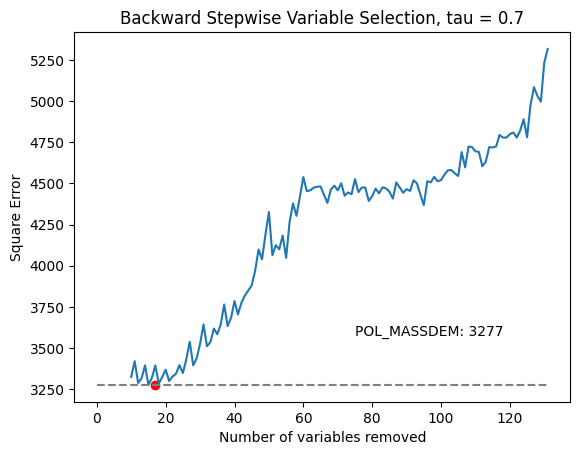

In [30]:
from matplotlib import pyplot as plt


plt.plot([131-n for n in range(len(removal_dict_7))], removal_dict_7.values())
min_value_col, min_value = sorted(removal_dict_7.items(), key=lambda item: item[1])[0]
plt.hlines(y = min_value, xmin=0, xmax=131, linestyles='--', colors='grey')
plt.annotate(f"{min_value_col}: {min_value}", (75, min_value+300))
plt.scatter(x = 17, y = min_value, c='r')
plt.xlabel("Number of variables removed")
plt.ylabel("Square Error")
plt.title("Backward Stepwise Variable Selection, tau = 0.7");

In [19]:
## try GA

## Try using genetic algorithm
def fitness_function(sim:simnet.similarity.CosineSimilarity):
    def f(ga_instance, solution, sol_index):

        # solution is a n = 131 vector, indicating include or not

        col_to_try = [cols_to_include[i] for i in range(len(solution)) if solution[i] == 1]
        sn = simnet.similarity.SimilarityNetwork(
            df,
            sim,
            col_to_try
        )
        W = sn.fit_transform().toarray()
        # G = sn.network.subgraph(dynamic.index)

        # W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
        diff = get_diffusion_diff(
            np.matrix(W),
            dynamic.to_numpy(dtype=int),
            0.5
        )
        return 1/diff
    return f

In [20]:
import pygad

ga_instance_8 = pygad.GA(
    num_generations=100,
    num_parents_mating=4,
    fitness_func=fitness_function(cosine_sim_8),
    sol_per_pop = 64,
    num_genes=len(cols_to_include),
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

ga_instance_7 = pygad.GA(
    num_generations=100,
    num_parents_mating=4,
    fitness_func=fitness_function(cosine_sim_7),
    sol_per_pop = 64,
    num_genes=len(cols_to_include),
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

In [21]:
ga_instance_7.run()

In [22]:
solution, solution_fitness, solution_idx = ga_instance_7.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))


Parameters of the best solution : [1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0
 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
Fitness value of the best solution = 3503.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


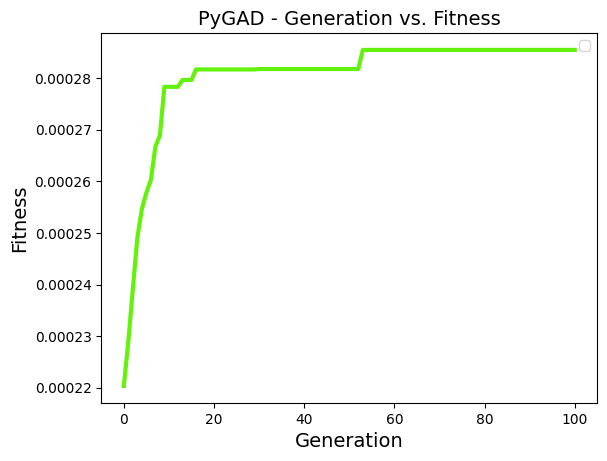

In [25]:
ga_instance_7.plot_fitness();

In [20]:
ga_instance_8.run()

In [61]:
solution, solution_fitness, solution_idx = ga_instance_8.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))


Parameters of the best solution : [0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0
 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0
 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0]
Fitness value of the best solution = 0.0003562522265764161


In [62]:
1/fitness_function(0,solution, 0)

2807.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


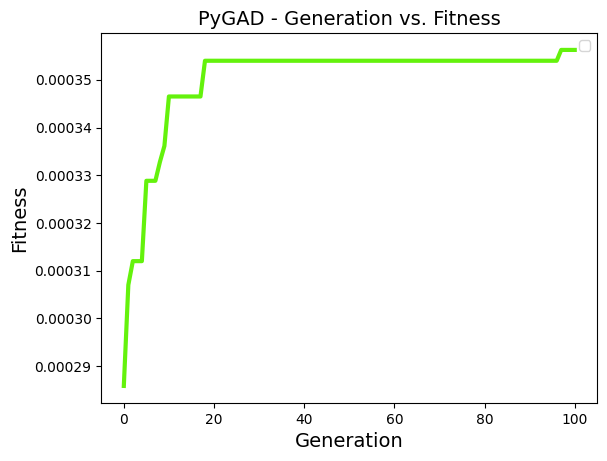

In [64]:
ga_instance_8.plot_fitness();

In [74]:
cols_to_include_for_removal = cols_to_include.copy()
solution_set = [1]*131
populations = []
for diff_dict in logging_8:
    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    worst_col =  list(rank_by_se.keys())[0] ## Add this columns yields the best performance improve
    to_remove_index = cols_to_include.index(worst_col)
    solution_set[to_remove_index] = 0
    populations.append(solution_set.copy())

# get 10 min


In [99]:
init_population = np.array(populations[:131-60])
print(init_population.shape)

ga_instance_from_stepwise = pygad.GA(
    num_generations=60,
    num_parents_mating=4,
    fitness_func=fitness_function,
    initial_population=init_population,
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

(71, 131)


In [100]:
ga_instance_from_stepwise.run()

In [102]:

solution, solution_fitness, solution_idx = ga_instance_from_stepwise.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=int(1/solution_fitness)))


Parameters of the best solution : [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1
 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1]
Fitness value of the best solution = 2777


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


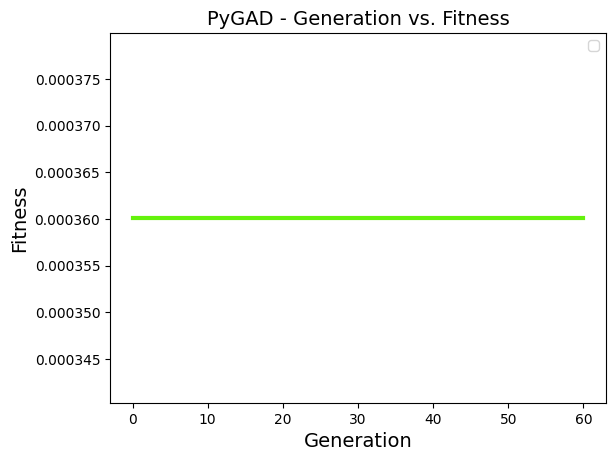

In [103]:
ga_instance_from_stepwise.plot_fitness();

In [104]:
with open("ga_step.pk", 'wb') as f:
    pickle.dump(ga_instance_from_stepwise, f)

## Try different cosine similarities

In [16]:
backward_different_cosine:dict[float, BackwardStepwise] = dict()

In [18]:

for cosine_threshold in np.arange(0.6,0.9,0.05):
    print("Processing:", cosine_threshold)
    cosine_sim = simnet.similarity.CosineSimilarity(cosine_threshold)
    bs = BackwardStepwise(
        traits_df=df,
        dynamic_df=dynamic,
        var_pool=cols_to_include,
        similarity_metric=cosine_sim,
        num_var_remain=10
    )

    bs.run()
    backward_different_cosine[cosine_threshold] = bs


Processing: 0.6
131	ISSU_ADDR_REPOFF	3707
130	POL_MAXHRS	3693
129	ISSU_ADDR_CP	3670
128	log_pop	3650
127	ISSU_ADDR_CRMPREV	3654
126	CP_PSP_ADVGRP	3635
125	PERS_EDU_MIN	3619
124	log_budget	3608
123	ISSU_ADDR_BOMB	3633
122	CP_PLAN	3603
121	TECH_WEB_COMPL	3594
120	EQ_REV_ON_BACK	3587
119	TECH_IFC_WARR	3566
118	ISSU_ADDR_RESRCH	3565
117	TECH_WEB_STOP	3551
116	TECH_TYP_TRACE	3536
115	ISSU_ADDR_SCH	3541
114	TECH_IFC_ADDHIS	3521
113	ISSU_ADDR_DRUG_ED	3519
112	CP_TRN_NEW	3511
111	TECH_FILE_GANG	3501
110	TECH_TYP_LPR	3499
109	TECH_IFC_DRVREC	3493
108	POL_VEHPURS	3479
107	EQ_SEC_MANUAL	3467
106	EQ_SEC_SEMIAUTO	3464
105	EQ_AUTH_BLNT	3470
104	TECH_FILE_PRTORD	3454
103	TECH_COMP_SNA	3459
102	POL_FOOT	3444
101	ISSU_ADDR_MISCHD	3444
100	EQ_UNI_CASH	3429
99	TECH_ILES_INTEL	3422
98	TECH_CIR	3415
97	ISSU_ADDR_DUI	3403
96	TECH_WEB_STAT	3394
95	ISSU_ADDR_SWAT	3395
94	ISSU_ADDR_DOM	3381
93	CP_MISSION	3372
92	OPER_MOTOPAT	3369
91	CP_SURV_RESOURCE	3378
90	EQ_REV_ON_PRIM	3376
89	OPER_BIKEPAT	3372
88	OPER_FOOT

In [21]:
backward_different_cosine

{0.6: <model_selection.stepwise.BackwardStepwise at 0x1e165f611d0>,
 0.65: <model_selection.stepwise.BackwardStepwise at 0x1e165f5af10>,
 0.7000000000000001: <model_selection.stepwise.BackwardStepwise at 0x1e151a17d10>,
 0.7500000000000001: <model_selection.stepwise.BackwardStepwise at 0x1e1519b7190>,
 0.8000000000000002: <model_selection.stepwise.BackwardStepwise at 0x1e165f72010>,
 0.8500000000000002: <model_selection.stepwise.BackwardStepwise at 0x1e1549cb5d0>,
 0.9000000000000002: <model_selection.stepwise.BackwardStepwise at 0x1e152ee9d10>}

In [35]:
import pickle

with open("bs_all.pk", "wb") as f:
    pickle.dump(
        {round(i, 2): v.logging for i,v in backward_different_cosine.items()}
        , f)

In [34]:
{round(i,2): v.logging for i,v in backward_different_cosine.items()}.keys()

dict_keys([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])

## Examine differnt cosine sim result

In [26]:
import pickle

with open("bs_all.pk", 'rb') as f:
    bs_all = pickle.load(f)

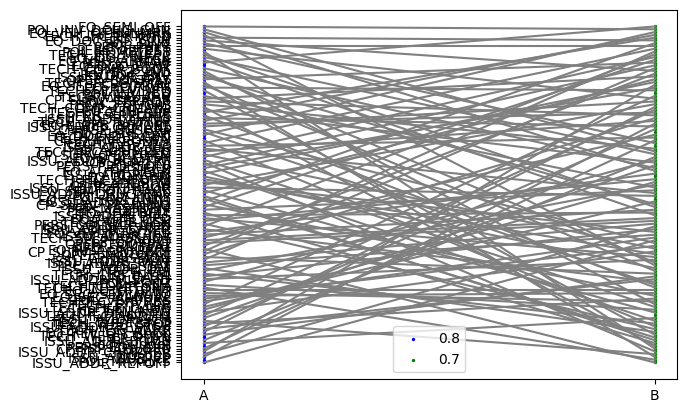

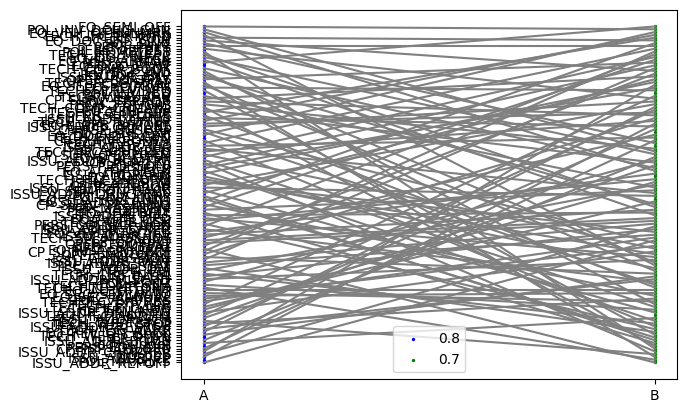

In [30]:
from model_selection.stepwise import StepwiseExaminer

bs_06 =  StepwiseExaminer(bs_all[0.6])
bs_07 = StepwiseExaminer(bs_all[0.7])

bs_06.compare_order_with(bs_07)

In [41]:
np.array( StepwiseExaminer(bs_all[0.7]).get_optimal_cols_set(2) )

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

## Optimal diffusion threshold?

When threshold of cosine similarity is 0.8, the p-value obtained from random rewiring is less than 0.05 only when the diffusion threshold is less than 0.4.

In [7]:
from functools import partial

bs_opt = BackwardStepwise(
        traits_df=df,
        dynamic_df=dynamic,
        var_pool=cols_to_include,
        similarity_metric=cosine_sim_8,
        num_var_remain=10
    )


In [ ]:
from functools import partial

bs_opt = BackwardStepwise(
        traits_df=df,
        dynamic_df=dynamic,
        var_pool=cols_to_include,
        similarity_metric=cosine_sim_8,
        num_var_remain=10
    )

# try getting optimal p
bs_opt.get_origin_p_value()


100%|██████████| 9/9 [06:58<00:00, 46.49s/it]


[0.01, 0.01, 0.05, 0.13, 0.23, 0.24, 0.47, 0.48, 0.44]

In [8]:

optimal_diffusion_fn = partial(get_diffusion_diff, th=0.3)
bs_opt.set_diffusion_diff_function(optimal_diffusion_fn)

bs_opt.run()


131	log_pop	3761
130	TECH_IFC_GISMAP	3616
129	EQ_VEH_MTRCYCL	3620
128	log_budget	3616
127	CP_SURV_TRAINING	3614
126	ISSU_ADDR_MISCHD	3442
125	PERS_APTEST	3427
124	TECH_WEB_STOP	3412
123	ISSU_ADDR_CP	3411
122	TECH_SM_TWITTER	3427
121	ISSU_ADDR_GUNS	3302
120	CP_PSP_BUSGRP	3295
119	TECH_COMP_SNA	3287
118	EQ_VEH_ARMOR	3293
117	TECH_WEB_ASK	3306
116	ISSU_ADDR_RESRCH	3164
115	TECH_FILE_INFORM	3166
114	TECH_IFC_MVREC	3170
113	TECH_FILE_PAWN	3177
112	TECH_COMP_BOOK	3210
111	ISSU_ADDR_CHILD	3112
110	AGENCYTYPE	3111
109	EQ_SEC_SHOTGUN	3106
108	TECH_IFC_PRTORD	3115
107	EQ_AUTH_EXP	3142
106	PERS_PHYS	3046
105	TECH_IFC_DRVREC	3038
104	CP_CPACAD	3042
103	EQ_BCK_CASH	3060
102	EQ_SEC_MANUAL	3072
101	ISSU_ADDR_GANG	3039
100	TECH_TYP_LPR	3036
99	TECH_COMP_CRMANL	3040
98	EQ_REV_OFF	3065
97	ISSU_ADDR_DRUG_ENF	3097
96	EQ_AUTH_LEG	3031
95	EQ_AUTH_CED	3046
94	OPER_MOTOPAT	3038
93	POL_TERROR	3058
92	EQ_DOC_CHEM	3085
91	EQ_BCK_IND	2928
90	ISSU_ADDR_CRMPREV	2933
89	TECH_IFC_INFSHR	2946
88	POL_MASSDEM	2975
87	CP

In [10]:
import pickle
with open("bs_opt.pk", 'wb') as f:
    pickle.dump(bs_opt, f)

In [11]:
bs_opt

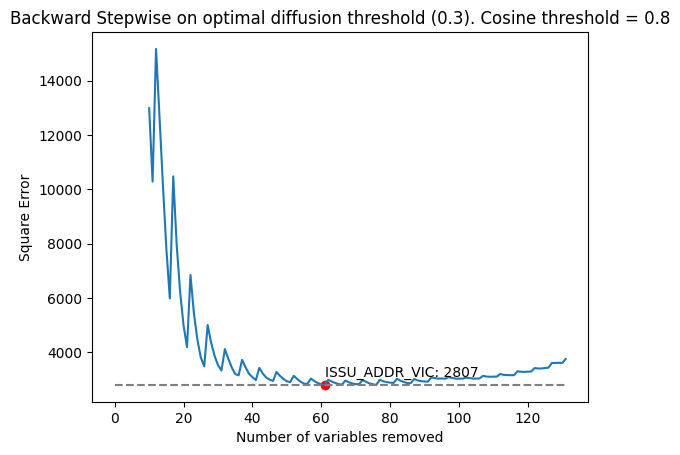

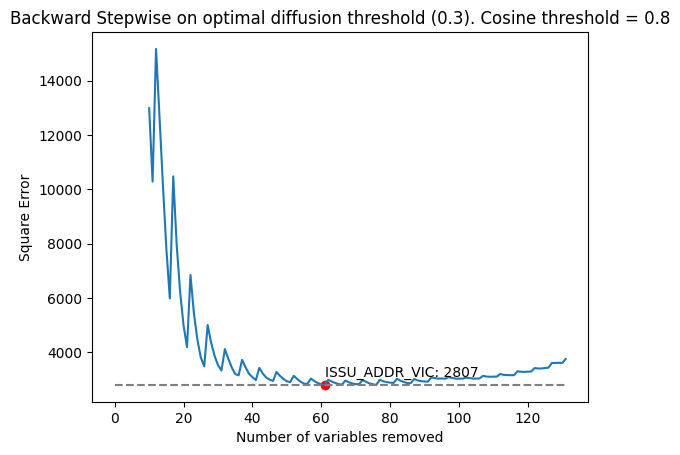

In [59]:
bs_opt.get_examiner().plot_score_evolution(title="Backward Stepwise on optimal diffusion threshold (0.3). Cosine threshold = 0.8")

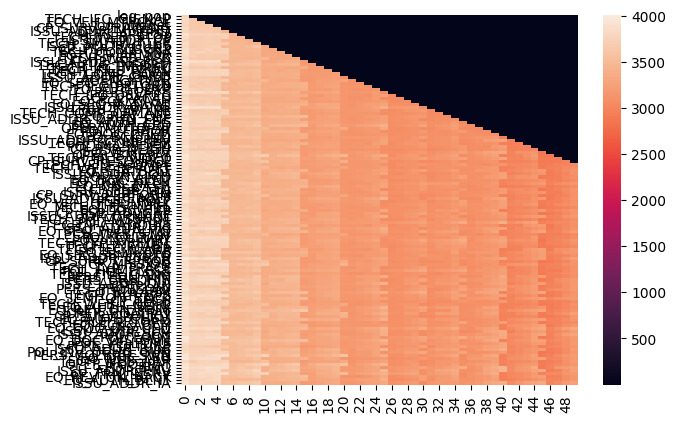

In [15]:
bs_opt.get_examiner().plot_heatmap(50);

## GA after optimal?

In [56]:

init_population = np.array(
bs_opt.get_examiner().get_optimal_cols_set(orig_cols=cols_to_include, n = 30)
)

ga_instance_from_stepwise = pygad.GA(
    num_generations=100,
    num_parents_mating=4,
    fitness_func=fitness_function(cosine_sim_8),
    initial_population=init_population,
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

In [57]:
ga_instance_from_stepwise.run()

In [62]:
def show_ga_performance(ga: pygad.GA):
    solution, solution_fitness, solution_idx = ga.best_solution()
    print("Parameters of the best solution : {solution}".format(solution=solution))
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))
    ga.plot_fitness();


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1
 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0
 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0]
Fitness value of the best solution = 2708.0


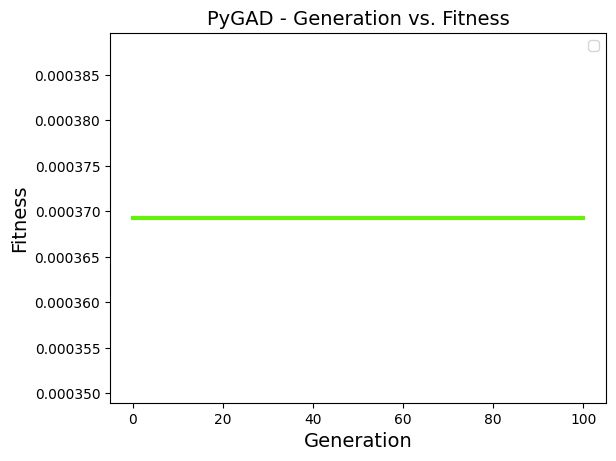

In [63]:
show_ga_performance(ga_instance_from_stepwise)

## GA on cosine_sim_07

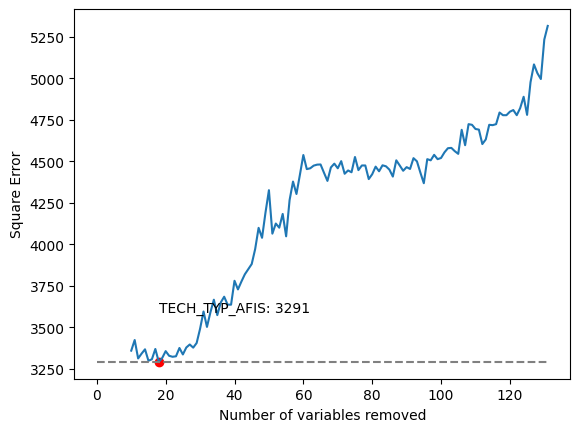

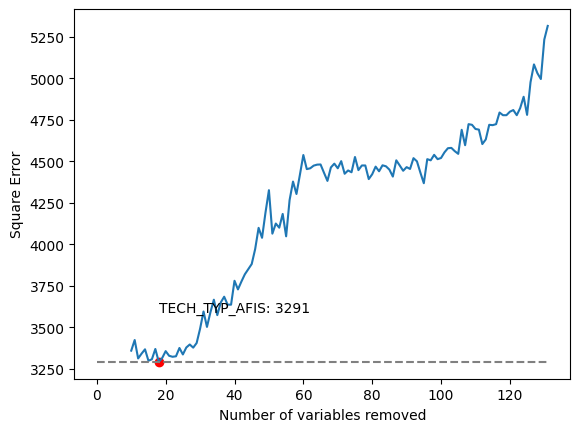

In [68]:
StepwiseExaminer(bs_all[0.7]).plot_score_evolution()

In [69]:

init_population = np.array(
StepwiseExaminer(bs_all[0.7]).get_optimal_cols_set(orig_cols=cols_to_include, n = 30)
)

ga_instance_from_stepwise_7 = pygad.GA(
    num_generations=100,
    num_parents_mating=4,
    fitness_func=fitness_function(cosine_sim_7),
    initial_population=init_population,
    mutation_percent_genes = 20,
    gene_space=[0,1],
    gene_type=int
)

In [70]:
ga_instance_from_stepwise_7.run()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Parameters of the best solution : [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Fitness value of the best solution = 3291.0000000000005


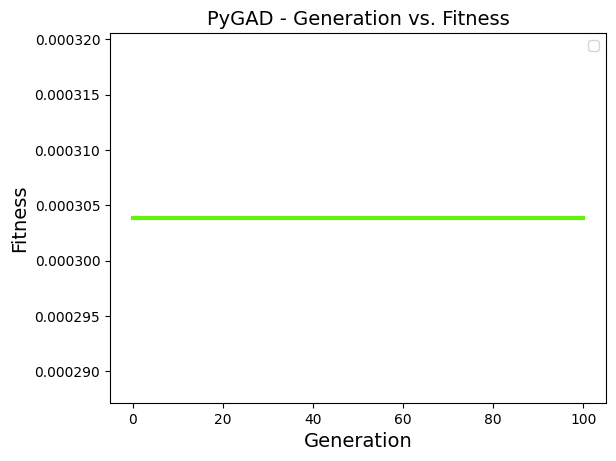

In [71]:
show_ga_performance(ga_instance_from_stepwise_7)

first GA, then greedy

1. Stepwise result
2. Cosine threshold = 0.9 performs best?
2. GA


benchmark: no dif/no sim network

vs

have some th, see improvement

## Improvement from adding threshold

In [74]:
from dotomorrow import SavedIterator

diffusion_threshold_space = range(1,10)

with SavedIterator('diff_th', diffusion_threshold_space) as si:
    for diff_th in tqdm(si):

        bs= BackwardStepwise(
                traits_df=df,
                dynamic_df=dynamic,
                var_pool=cols_to_include,
                similarity_metric=cosine_sim_7,
                num_var_remain=10
            )

        optimal_diffusion_fn = partial(get_diffusion_diff, th = 0.1 * diff_th)
        bs.set_diffusion_diff_function(optimal_diffusion_fn)
        bs.run()

        si += bs

Cache found in diff_th. 9 iterations remained.


0it [00:00, ?it/s]

131	log_pop	25501
130	log_budget	25396
129	TECH_IFC_MVREC	25539
128	CP_SURV_CRPROB	25834
127	EQ_SEATBELT	23961
126	TECH_IFC_WARR	24276
125	EQ_SEC_SEMIAUTO	24512
124	EQ_BCK_CASH	22306
123	TECH_IFC_ADDHIS	22693
122	EQ_VEH_MTRCYCL	23057
121	TECH_FILE_GANG	21323
120	EQ_AUTH_EXP	21743
119	CP_SURV_PERFORM	22228
118	TECH_WEB_STOP	22750
117	EQ_VEH_OTHUNMRK	20801
116	TECH_IFC_DRVREC	21284
115	EQ_REV_OFF	21766
114	EQ_BDYARM	19881
113	CP_CPACAD	20418
112	EQ_DOC_EXP	20923
111	ISSU_ADDR_MISCHD	19137
110	TECH_WEB_ASK	19640
109	CP_SURV_TRAINING	20183
108	EQ_SEC_SHOTGUN	20795
107	TECH_COMP_CRMANL	18717
106	EQ_DOC_CHEM	19247
105	CP_TECH	19893
104	EQ_SEC_MANUAL	17905
103	AGENCYTYPE	18494
102	EQ_BCK_AGCY	19067
101	ISSU_ADDR_DOM	19665
100	EQ_DOC_BLNT	17826
99	TECH_SM_TWITTER	18386
98	TECH_TYP_AFIS	19033
97	CP_PSP_NEIGH	17004
96	EQ_AUTH_CED	17630
95	POL_INV_ICD	18359
94	POL_MASSDEM	16415
93	TECH_FILE_COMPL	17000
92	EQ_VEH_ARMOR	17651
91	TECH_CIR	16624
90	CP_PSP_BUSGRP	17360
89	TECH_TYP_LPR	18125
88	EQ_SEMI

1it [35:41, 2141.19s/it]

10	ISSU_ADDR_ENV	33478
131	CP_SURV_POLICY	19504
130	TECH_IFC_MVREC	19293
129	EQ_SEATBELT	18775
128	EQ_SEC_SEMIAUTO	18688
127	log_pop	18504
126	TECH_IFC_WARR	18533
125	CP_SURV_TRAINING	18033
124	log_budget	17593
123	EQ_BCK_CASH	17755
122	EQ_DOC_EXP	17919
121	TECH_WEB_STOP	16705
120	TECH_IFC_PRTORD	16820
119	EQ_AUTH_EXP	17137
118	CP_PSP_LEA	17454
117	TECH_IFC_ADDHIS	16388
116	EQ_VEH_MTRCYCL	16636
115	CP_TECH	16946
114	TECH_IFC_DRVREC	15820
113	CP_CPACAD	15989
112	EQ_SEC_SHOTGUN	16397
111	EQ_DOC_CHEM	15428
110	PERS_CREDHIS	15645
109	CP_SURV_PERFORM	15914
108	EQ_VEH_ARMOR	16343
107	ISSU_ADDR_CRMPREV	15259
106	TECH_COMP_CRMANL	15592
105	EQ_REV_OFF	16000
104	EQ_VEH_OTHUNMRK	14653
103	TECH_WEB_ASK	14974
102	TECH_TYP_TRACE	15356
101	EQ_SEC_MANUAL	14030
100	CP_PSP_BUSGRP	14328
99	ISSU_ADDR_DOM	14694
98	POL_MASSDEM	15196
97	TECH_FILE_GANG	13741
96	CP_SURV_CRPROB	14124
95	CP_PSP_NEIGH	14697
94	OPER_MOTOPAT	13187
93	CP_PSP_ADVGRP	13606
92	ISSU_ADDR_MISCHD	14206
91	POL_INV_INJRY	12750
90	POL_FOOT	1

2it [1:12:28, 2179.92s/it]

10	TECH_IFC_CRIMREC	24620
131	PERS_PHYS	13834
130	EQ_SEC_SEMIAUTO	13793
129	CP_SURV_POLICY	13400
128	EQ_REV_ON_PRIM	13183
127	EQ_SEATBELT	13205
126	TECH_WEB_STOP	12924
125	TECH_IFC_ADDHIS	12853
124	CP_PSP_BUSGRP	12670
123	TECH_WEB_ASK	12623
122	CP_TECH	12683
121	TECH_FILE_PRTORD	12509
120	EQ_UNI_CASH	12461
119	TECH_IFC_DRVREC	12203
118	TECH_FILE_INFORM	12155
117	EQ_AUTH_NECK	12110
116	EQ_VEH_OTHUNMRK	11819
115	log_budget	11845
114	EQ_DOC_EXP	11800
113	CP_SURV_PERFORM	11849
112	PERS_APTEST	11681
111	CP_PLAN	11621
110	log_pop	11632
109	EQ_SEC_MANUAL	11723
108	CP_PSP_NEIGH	11822
107	ISSU_ADDR_SCH	11639
106	EQ_BCK_CASH	11762
105	CP_CPACAD	11944
104	PERS_CREDHIS	11502
103	EQ_AUTH_EXP	11462
102	ISSU_ADDR_DUI	11666
101	TECH_CIR	11643
100	CP_SURV_CRPROB	11663
99	TECH_IFC_MVREC	11734
98	TECH_IFC_WARR	11812
97	EQ_DOC_NECK	11192
96	EQ_VEH_MTRCYCL	11262
95	CP_SURV_TRAINING	11579
94	TECH_IFC_INFSHR	10818
93	TECH_TYP_TRACE	11077
92	TECH_COMP_CRMANL	11255
91	ISSU_ADDR_MISCHD	10736
90	CP_PSP_LEA	10922

3it [1:47:43, 2150.47s/it]

10	ISSU_ADDR_DRUG_ENF	15438
131	TECH_IFC_WARR	8616
130	EQ_REV_ON_PRIM	8567
129	ISSU_ADDR_JUV	8236
128	EQ_SEC_MANUAL	8198
127	PERS_PHYS	8183
126	TECH_WEB_ASK	8025
125	EQ_UNI_CASH	8059
124	EQ_SEATBELT	7928
123	TECH_WEB_STOP	7834
122	log_budget	7900
121	ISSU_ADDR_RESRCH	8004
120	TECH_FILE_PRTORD	7758
119	TECH_IFC_ADDHIS	7694
118	TECH_FILE_VIDEO	7757
117	EQ_VEH_OTHUNMRK	7642
116	CP_PLAN	7475
115	POL_INV_DCHG_GUN	7521
114	POL_FOOT	7497
113	PERS_CREDHIS	7418
112	CP_PSP_NEIGH	7345
111	EQ_SEC_SEMIAUTO	7403
110	CP_MISSION	7355
109	TECH_IFC_DRVREC	7216
108	ISSU_ADDR_DRUG_ED	7247
107	TECH_TYP_LPR	7221
106	EQ_AUTH_NECK	7247
105	ISSU_ADDR_MISCHD	7105
104	ISSU_ADDR_HUMTRF	7234
103	POL_HOMELESS	7194
102	CP_SURV_TRAINING	7008
101	POL_INV_ICD	7062
100	EQ_BCK_CASH	7134
99	TECH_IFC_PRTORD	7036
98	EQ_DOC_DIS_CED	6858
97	AGENCYTYPE	6809
96	TECH_COMP_CRMANL	6953
95	OPER_FOOTPAT	6884
94	CP_SURV_RESOURCE	6885
93	TECH_IFC_MVREC	6918
92	TECH_ILES_INTEL	6746
91	PERS_EDU_MIN	6871
90	CP_PSP_LEA	6904
89	TECH_IFC_CR

4it [2:22:28, 2124.51s/it]

10	TECH_IFC_GISMAP	5971
131	EQ_REV_ON_PRIM	5316
130	TECH_FILE_PRTORD	5234
129	TECH_IFC_GISMAP	4996
128	TECH_TYP_TRACE	5031
127	CP_PSP_LEA	5084
126	POL_HOMELESS	4977
125	TECH_COMP_CRMANL	4780
124	EQ_SEATBELT	4889
123	POL_INV_INJRY	4821
122	EQ_SEC_FULLAUTO	4778
121	TECH_FILE_VIDEO	4809
120	ISSU_ADDR_DUI	4799


4it [2:29:43, 2245.82s/it]


PicklingError: Can't pickle <class 'model_selection.stepwise.BackwardStepwise'>: it's not the same object as model_selection.stepwise.BackwardStepwise